
------------|--------------|------|----------|----------|--------------|--------------|----------------
 Eb/NO (dB) | Frame number |  FE  |    BER   |    FER   |  Tpt (Mbps)  | Elapsed Time | Remaining Time 
------------|--------------|------|----------|----------|--------------|--------------|----------------


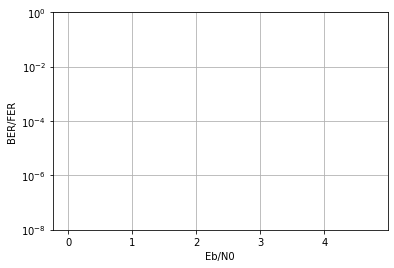

       0.00 |         1016 | 1010 | 1.75e-01 | 9.94e-01 |          1.63|     00:00:00 |       00:00:00
       0.25 |         1032 | 1011 | 1.60e-01 | 9.80e-01 |          1.86|     00:00:00 |       00:00:00
       0.50 |         1080 | 1012 | 1.43e-01 | 9.37e-01 |          2.30|     00:00:00 |       00:00:00
       0.75 |         1176 | 1008 | 1.20e-01 | 8.57e-01 |          2.64|     00:00:00 |       00:00:00
       1.00 |         1408 | 1007 | 9.23e-02 | 7.15e-01 |          1.96|     00:00:00 |       00:00:00
       1.25 |         1944 | 1005 | 6.17e-02 | 5.17e-01 |          2.47|     00:00:00 |       00:00:00
       1.50 |         3480 | 1001 | 3.25e-02 | 2.88e-01 |          2.56|     00:00:00 |       00:00:00
       1.75 |         7128 | 1000 | 1.52e-02 | 1.40e-01 |          3.18|     00:00:00 |       00:00:00
       2.00 |        20208 | 1001 | 4.92e-03 | 4.95e-02 |          4.66|     00:00:01 |       00:00:00
       2.25 |        80352 | 1001 | 1.21e-03 | 1.25e-02 |          7.04| 

In [5]:
# To add a new cell, type '# %%'
# To add a new markdown cell, type '# %% [markdown]'
# %%
import sys
sys.path.insert(0, '../../build/lib')

import numpy as np
import py_aff3ct as aff3ct
import py_aff3ct.tools.sparse_matrix as sp
from py_signal_catcher import signal_catcher

import math
import time
import threading
import matplotlib.pyplot as plt


# %%
T = 4

H   = sp.alist.read("../../lib/aff3ct/conf/dec/LDPC/WIMAX_288_576.alist")
N  = H.shape[0]
m  = H.shape[1]
K  = N-m
R  = K/N

I = 100

FE = 1000

n_frames = 8

ebn0_min = 0
ebn0_max = 5.0
ebn0_step = 0.25

ebn0 = np.arange(ebn0_min,ebn0_max,ebn0_step)
esn0 = ebn0 + 10 * math.log10(R)
sigma_vals = 1/(math.sqrt(2) * 10 ** (esn0 / 20))


# %%
src = aff3ct.module.source.Source_random_fast(K)
enc = aff3ct.module.encoder.Encoder_LDPC_from_QC(K,N,H)
dec = aff3ct.module.decoder.Decoder_LDPC_BP_horizontal_layered_inter_NMS(K,N,I,H,enc.get_info_bits_pos())
mdm = aff3ct.module.modem.Modem_BPSK_fast(N)
gen = aff3ct.tools.Gaussian_noise_generator_implem.FAST
chn = aff3ct.module.channel.Channel_AWGN_LLR(N, gen)
mnt = aff3ct.module.monitor.Monitor_BFER_AR(K, FE)
sgc = signal_catcher()

# %%
enc["encode       ::U_K "] = src["generate   ::U_K "   ]
mdm["modulate     ::X_N1"] = enc["encode     ::X_N "   ]
chn["add_noise    ::X_N "] = mdm["modulate   ::X_N2"   ]
mdm["demodulate   ::Y_N1"] = chn["add_noise  ::Y_N "   ]
dec["decode_siho  ::Y_N "] = mdm["demodulate ::Y_N2"   ]
mnt["check_errors ::U   "] = src["generate   ::U_K "   ]
mnt["check_errors ::V   "] = dec["decode_siho::V_K "   ]

sgc["do_nothing"         ] = mnt["check_errors::status"]

aff3ct.tools.sequence.Sequence(src["generate"], 1).set_n_frames(n_frames)

sigma = np.ndarray(shape = (n_frames,1),  dtype = np.float32)
chn["add_noise    ::CP  "] = sigma
mdm["demodulate   ::CP  "] = sigma
# %%
seq  = aff3ct.tools.sequence.Sequence(src["generate"], T)

# %%
class seq_execution(threading.Thread):
    def __init__(self, seq):
        threading.Thread.__init__(self)
        self.seq = seq
        self.starting_time = time.time()

    def run(self):
        self.starting_time = time.time()
        self.seq.exec()


# %%
l_tasks = seq.get_tasks_per_types()
for lt in l_tasks:
    for t in lt:
        t.stats = True
        #t.debug = True

seeders = seq.get_modules_set_seed()
for mdl in seeders:
    mdl.set_seed(np.random.randint(3242, dtype=int))


# %%
fer = np.zeros(len(ebn0))
ber = np.zeros(len(ebn0))

fig = plt.figure()
ax = fig.add_subplot(111)
line1,line2, = ax.semilogy(ebn0, fer, 'r-', ebn0, ber, 'b--', nonpositive='mask') # Returns a tuple of line objects, thus the comma
plt.ylim((1e-8, 1))
plt.xlabel("Eb/N0")
plt.ylabel("BER/FER")
plt.grid()
print("")
print("------------|--------------|------|----------|----------|--------------|--------------|----------------")
print(" Eb/NO (dB) | Frame number |  FE  |    BER   |    FER   |  Tpt (Mbps)  | Elapsed Time | Remaining Time ")
print("------------|--------------|------|----------|----------|--------------|--------------|----------------")

for i in range(len(sigma_vals)):
    mnt.reset()
    se = seq_execution(seq=seq)
    se.start() # start simulation threads

    # Main thread : update display (console and curves)
    sigma[:,:] = sigma_vals[i]
    remaining = 0
    while se.is_alive():

        elapsed   = time.time() - se.starting_time
        total_fra = mnt.get_n_analyzed_fra()
        ber[i]    = mnt.get_ber()
        fer[i]    = mnt.get_fer()
        n_fe      = mnt.get_n_fe()
        tpt       = total_fra * K * 1e-6/elapsed

        if n_fe == 0:
            print("%11.2f | %12d | %4d |       -- |       -- |           -- | %12s | %14s"%(ebn0[i], total_fra, n_fe, time.strftime('%H:%M:%S', time.gmtime(elapsed)), '--:--:--'), end="\r")
        else:
            remaining = max((elapsed/n_fe)*(FE-n_fe),0)
            print("%11.2f | %12d | %4d | %7.2e | %7.2e | %13.2f| %12s | %14s"%(ebn0[i], total_fra, n_fe, ber[i], fer[i], tpt, time.strftime('%H:%M:%S', time.gmtime(elapsed)), time.strftime('%H:%M:%S', time.gmtime(remaining))), end="\r")

        line1.set_ydata(fer)
        line2.set_ydata(ber)
        fig.canvas.draw()
        fig.canvas.flush_events()
        plt.pause(0.05)
        #time.sleep(0.125)

    elapsed   = time.time() - se.starting_time
    total_fra = mnt.get_n_analyzed_fra()
    ber[i]    = mnt.get_ber()
    fer[i]    = mnt.get_fer()
    n_fe      = mnt.get_n_fe()
    tpt       = total_fra * K * 1e-6/elapsed
    if n_fe >= FE:
        print("%11.2f | %12d | %4d | %7.2e | %7.2e | %13.2f| %12s | %14s"%(ebn0[i], total_fra, n_fe, ber[i], fer[i], tpt, time.strftime('%H:%M:%S', time.gmtime(elapsed)), time.strftime('%H:%M:%S', time.gmtime(0))), end="\n")
    else:
        print("%11.2f | %12d | %4d | %7.2e | %7.2e | %13.2f| %12s | %14s x"%(ebn0[i], total_fra, n_fe, ber[i], fer[i], tpt, time.strftime('%H:%M:%S', time.gmtime(elapsed)), time.strftime('%H:%M:%S', time.gmtime(0.00))), end="\n")
        break

print("")
seq.show_stats()
plt.show()